# Adding Phase to AddBiomechanics datasets

Step 1: GRF thresholding (20 Nm)
Step 2: Transition identification by taking diff
Step 3: Determine steady state tasks by looking at stride timing
Step 4: Lienarly interpolate phase for all steady state tasks
Step 5: Create another dataset with phase being the main axis (phase divided 
        into 150 points)

In [21]:
# Import stuff, load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load data
df = pd.read_parquet('Camargo2021_Formatted_No_Arm.parquet')
df.columns

Index(['subject', 'task', 'time_step', 'contact_r', 'contact_l', 'GRF_x_r',
       'GRF_y_r', 'GRF_z_r', 'GRF_x_l', 'GRF_y_l', 'GRF_z_l', 'COP_x_r',
       'COP_y_r', 'COP_z_r', 'COP_x_l', 'COP_y_l', 'COP_z_l', 'pelvis_angle_s',
       'pelvis_angle_f', 'pelvis_angle_t', 'hip_angle_s_r', 'hip_angle_f_r',
       'hip_angle_t_r', 'knee_angle_s_r', 'ankle_angle_s_r', 'ankle_angle_t_r',
       'hip_angle_s_l', 'hip_angle_f_l', 'hip_angle_t_l', 'knee_angle_s_l',
       'ankle_angle_s_l', 'ankle_angle_t_l', 'dorsi_angle_r', 'dorsi_angle_l',
       'shank_angle_r', 'shank_angle_l', 'thigh_angle_r', 'thigh_angle_l',
       'shank_vel_r', 'shank_vel_l', 'thigh_vel_r', 'thigh_vel_l',
       'ankle_vel_r', 'ankle_vel_l', 'pelvis_vel_s', 'pelvis_vel_f',
       'pelvis_vel_t', 'hip_vel_s_r', 'hip_vel_f_r', 'hip_vel_t_r',
       'knee_vel_s_r', 'ankle_vel_s_r', 'ankle_vel_t_r', 'hip_vel_s_l',
       'hip_vel_f_l', 'hip_vel_t_l', 'knee_vel_s_l', 'ankle_vel_s_l',
       'ankle_vel_t_l', 'pelvis_tau_s'

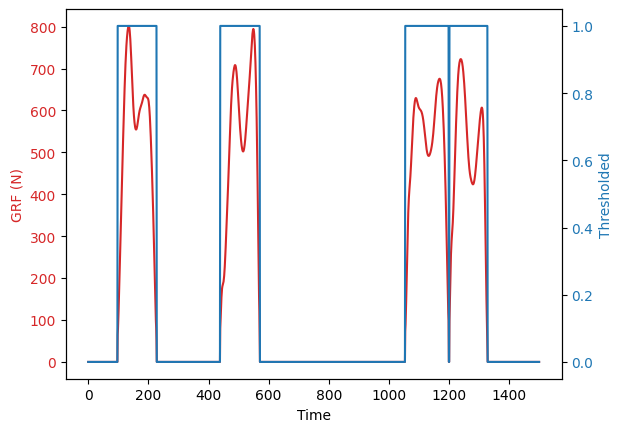

In [11]:
# Step 1: GRF thresholding for the z axis
grf_r = df['GRF_y_r'].values # Bug, should be z axis but it's currently the y axis
grf_threshold = 20 # N
grf_thresh = grf_r > grf_threshold

# Plot both the raw and thresholded data in the same plot with 
# two different y axes
fig, ax1 = plt.subplots()

# Plot the first 150 points
start = 1500
end = start + 1500
grf_r_plot = grf_r[start:end]
grf_thresh_plot = grf_thresh[start:end]

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('GRF (N)', color=color)
ax1.plot(grf_r_plot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Thresholded', color=color)
ax2.plot(grf_thresh_plot, color=color)
ax2.tick_params(axis='y', labelcolor=color)


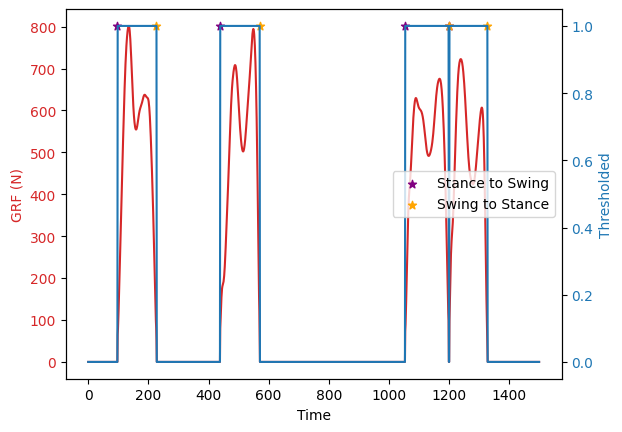

In [19]:
#Step 2: Find the start and end of the stance phase
# Use diff to find the stransitions from stance to swing
grf_thresh_diff = np.diff(grf_thresh.astype(int))

# Find the start and end of the stance phase
swing_to_stance = np.where(grf_thresh_diff == 1)[0]
stance_to_swing = np.where(grf_thresh_diff == -1)[0]

# Replicate the same plot, but with the stance to swing transitions and 
# stance to swing transitions as asterisk markers
start = 1500
end = start + 1500
grf_r_plot = grf_r[start:end]

# cutoff the transitions to be within the plot range
swing_to_stance_plot = swing_to_stance[(swing_to_stance > start) & (swing_to_stance < end)]
stance_to_swing_plot = stance_to_swing[(stance_to_swing > start) & (stance_to_swing < end)]

# Plot the first 150 points
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('GRF (N)', color=color)
ax1.plot(grf_r_plot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Thresholded', color=color)
ax2.plot(grf_thresh_plot, color=color)
ax2.tick_params(axis='y', labelcolor=color)

y_scatter = np.ones_like(swing_to_stance_plot)

ax2.scatter(swing_to_stance_plot - start, y_scatter, color='purple', marker='*', label = 'Stance to Swing')
ax2.scatter(stance_to_swing_plot - start, y_scatter, color='orange', marker='*', label = 'Swing to Stance')
ax2.legend()



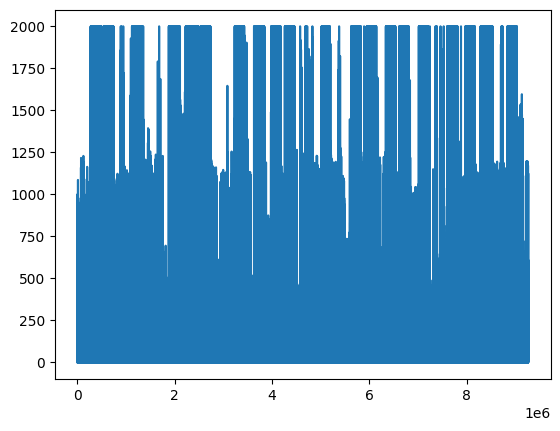

In [23]:
# Step 3: Calculate the stance phase duration

# Verify that time is reasonable
time = df['time_step'].values

# Plot the time for the dataset
plt.plot(time)


/home/jmontp/.conda/envs/jmontp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jmontp/.conda/envs/jmontp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Number of valid strides: 22295


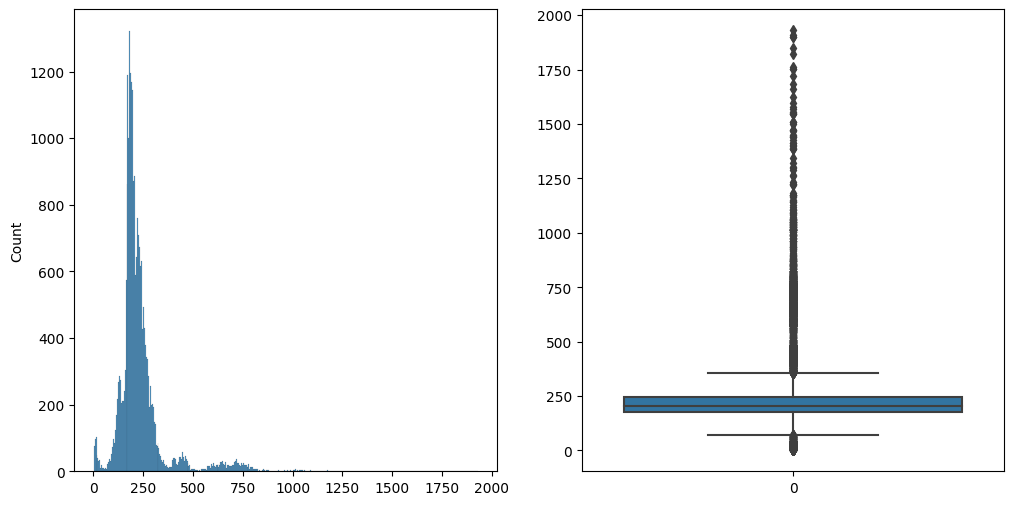

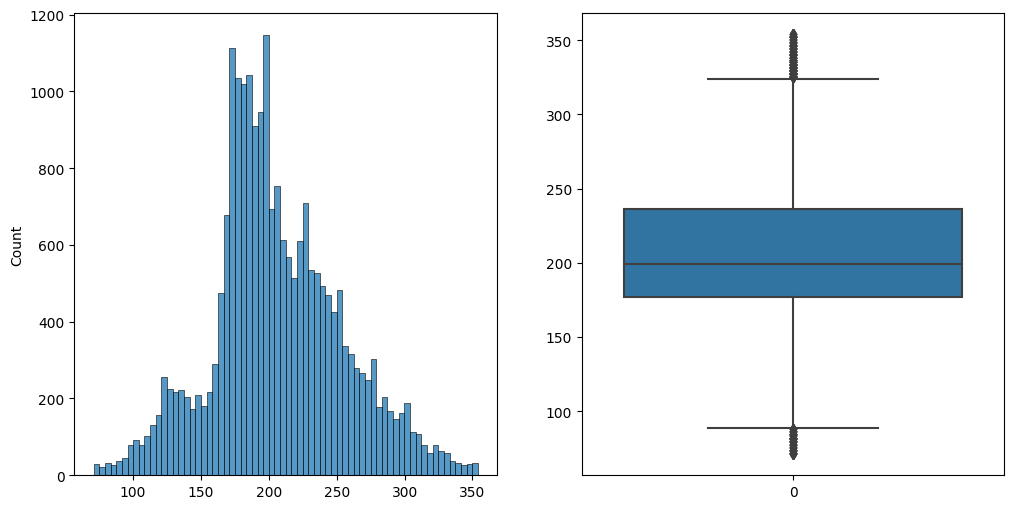

In [32]:
# Step 3 continued: Calculate the stance phase duration

# Calculate the stride time for each step. This is defined as the 
# time between consecutive swing to stance transitions. We want to create 
# a histogram of the stride time to identify the reasonable range of
# stride times. The unreasonable stride times will be removed from the
# dataset.

# Calculate the stride time
stride_time = time[swing_to_stance[1:]] - time[swing_to_stance[:-1]]

# Create a list that contains the indexes of the valid strides
valid_stride = np.arange(len(stride_time))

# First, remove the negative stride times
positive_strides = stride_time > 0
stride_time = stride_time[positive_strides]
valid_stride_num = valid_stride[positive_strides]

# Histogram of the stride time next to the box plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(stride_time, ax=ax[0])
sns.boxplot(stride_time, ax=ax[1])

# Remove all the outliers of the box plot
q1 = np.percentile(stride_time, 25)
q3 = np.percentile(stride_time, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove the outliers
in_bounds_strides = (stride_time > lower_bound) & (stride_time < upper_bound)
stride_time = stride_time[in_bounds_strides]
valid_stride_num = valid_stride_num[in_bounds_strides]

# Plot the histogram and box plot again
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(stride_time, ax=ax[0])
sns.boxplot(stride_time, ax=ax[1])

print(f"Number of valid strides: {len(stride_time)}")


In [33]:
# Step 4: Calculate the phase duration 
# Calculate the phase duration for each step. This is defined as a linear 
# interpolation between 0 and 1 from consecutive swing to stance transitions.

phase_list = []
valid_data_points = []
# Calculate the stride phase for each step 
for valid_stride in valid_stride_num:
    
    # Get the start and end of the stride
    start = swing_to_stance[valid_stride]
    end = swing_to_stance[valid_stride+1]
    
    # Calculate the phase
    phase = np.linspace(0, 1, end - start + 1)
    phase_list.extend(phase)

    # Calculate the valid points in the df
    stride_points = np.arange(start, end+1)
    valid_data_points.extend(stride_points)

# Filter the data frame to only include the valid data points
df_filtered = df.iloc[valid_data_points,:]

# Add the phase to the filtered data frame
df_filtered['phase'] = phase_list

# Print number of valid data points
print(f"Number of valid data points: {len(df_filtered)}")
print(f"Average data points per stride: {len(df_filtered) / len(stride_time)}")

Number of valid data points: 5372281
Average data points per stride: 240.96348957165284


/tmp/ipykernel_1771986/452766977.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['phase'] = phase_list


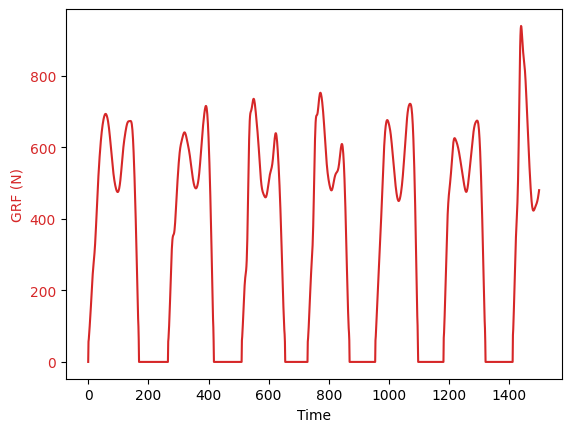

In [34]:
# Visualize the data

# Plot the first 1500 points of the GRF data
grf_new_data = df_filtered['GRF_y_r'].values

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('GRF (N)', color=color)
ax1.plot(grf_new_data[:1500], color=color)
ax1.tick_params(axis='y', labelcolor=color)
